In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets

from src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph


In [5]:
device = 'cuda'
figure_dir = Path('../learn_rep/figures/cppn')
# figure_dir = None
B = 128
N = 16
G = 32

In [10]:
root = Path(r'C:\Users\anwan\Documents\workspace\exts')
run_names = os.listdir(str(root))
run_names = [r for r in run_names if 'cppn' in r]
len(run_names)

12

In [11]:
print(tabulate(enumerate(run_names)))

--  -----------------------------------------------
 0  cppn_ae_e-c12_d-c12_210424-021457
 1  cppn_ae_e-c12_d-s12_210424-021456
 2  cppn_ae_e-c12_d-s12_210424-021457
 3  cppn_ae_e-c12_d-s12_n6_210424-022637
 4  cppn_ae_e-c12_d-s12_scm-n6_210424-022639
 5  cppn_ae_e-c12_d-s12_scm-nlin-n6_210424-022638
 6  cppn_vae1_e-c12_d-c12_210424-021458
 7  cppn_vae1_e-c12_d-c12_n6_210424-022636
 8  cppn_vae1_e-c12_d-c12_scm-n6_210424-022637
 9  cppn_vae1_e-c12_d-c12_scm-nlin-n6_210424-022637
10  cppn_vae2_e-c12_d-c12_210424-021503
11  cppn_wae10_e-c12_d-c12_210424-021458
--  -----------------------------------------------


In [25]:
run_name = run_names[7] # s12 mish
# run_name = run_names[5] # s12
# run_name = random.choice(run_names)
# run_name = run_names[0] # ae conv
# run_name = run_names[27] # l12
run_name = run_names[1]

# run_name = run_names[41]

# run_name = '3ds_vae2_e-c12_d-c12_210125-045344'
# run_name = '3ds_vae1_e-l12_d-l12_210125-045439'
# run_name = '3ds_vae16_e-c12_d-c12_210125-045345'

# run_name = short[0]


run_name

'cppn_ae_e-c12_d-s12_210424-021456'

In [26]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)

In [27]:
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'arch_type': 'strc',
 'dataset_type': 'cppn',
 'dec_type': 's12',
 'enc_type': 'c12',
 'model_type': 'ae',
 'size': 64}

In [28]:
dataset = run.get_dataset()
dataset.switch_to('val')
len(dataset)

10000

In [29]:
model = run.get_model()
model.switch_to('val')
model.to(device);

Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

Loaded parameters from C:\Users\anwan\Documents\workspace\exts\cppn_ae_e-c12_d-s12_210424-021456\ckpt100000


In [34]:
# if R is None:
#     with torch.no_grad():
#         R, Q = model(X, ret_q=True)
#         if isinstance(Q, distrib.Distribution):
#             Q = Q.loc

In [35]:
# util.show_imgs(X[:N])
# plt.suptitle('Original')
# plt.subplots_adjust(top=0.95)
# util.show_imgs(R[:N])
# plt.suptitle('Reconstructions')
# plt.subplots_adjust(top=0.95)
# pass

In [30]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
fullQ.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [31]:
scales = fullQ.std(0)
# scales = None

<IPython.core.display.Javascript object>


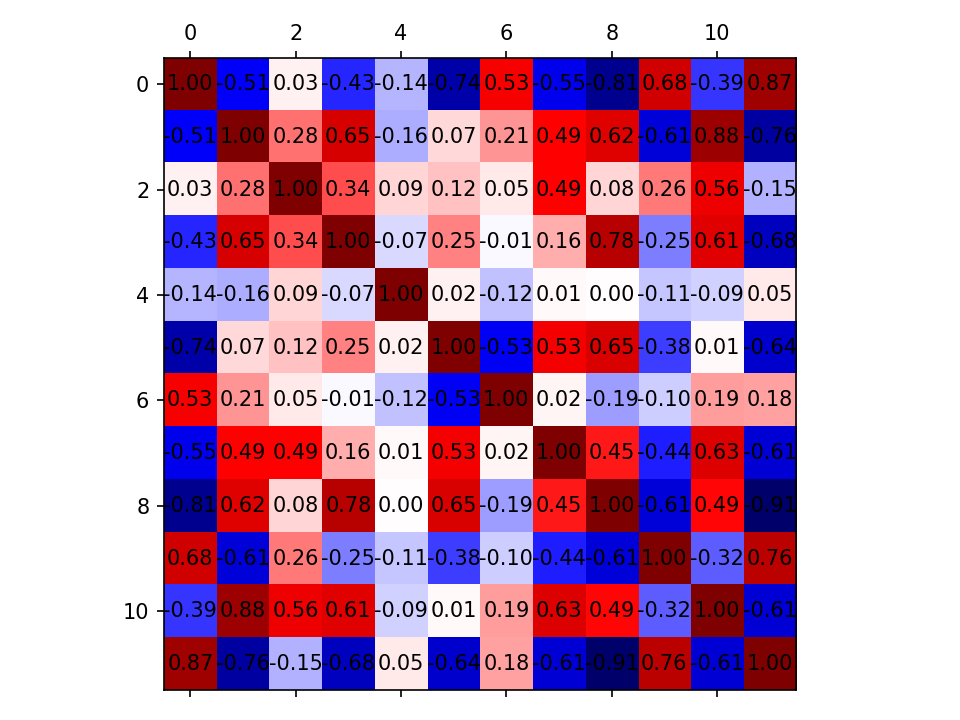

In [32]:
C = np.cov(fullQ.div(scales).cpu().t().numpy())
util.plot_mat(C, val_fmt=2, cmap='seismic', vmin=-1, vmax=1)
plt.tight_layout()
# util.save_figure(f'{run_name}_cov', root=figure_dir)
# util.save_figure(f'cov', root=figure_dir)

In [33]:
R = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, dist_type='rms', force_different=True)

<IPython.core.display.Javascript object>


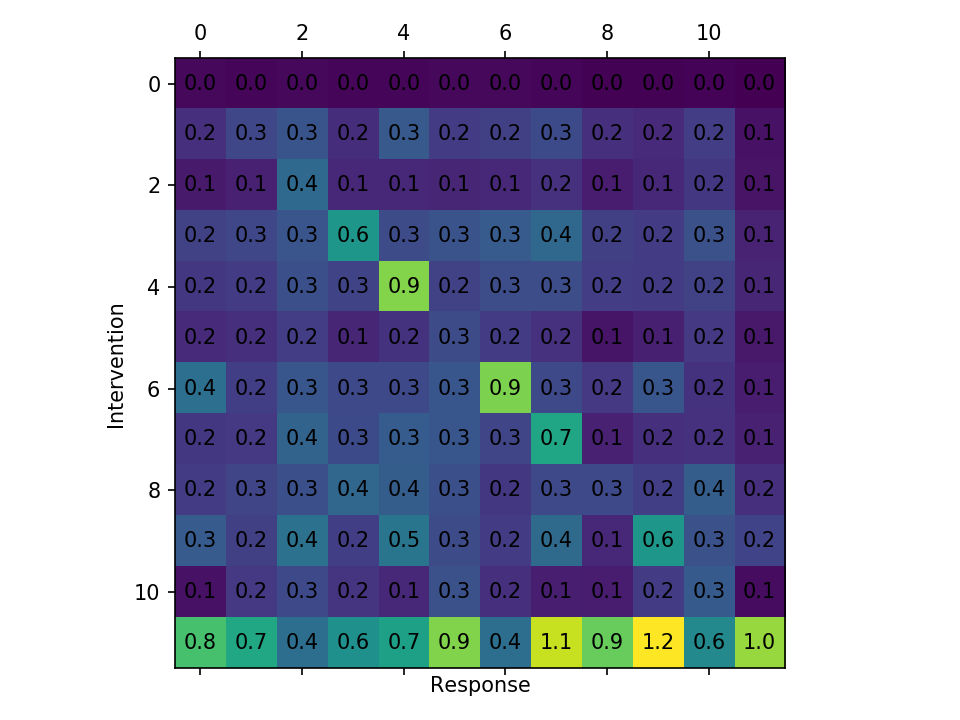

In [34]:
util.plot_mat(R, val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.tight_layout();
# util.save_figure(f'{run_name}_full_responses', root=figure_dir)
# util.save_figure(f'full_responses', root=figure_dir)

In [64]:
import networkx as nx

In [65]:
sel = torch.arange(len(R))[R.diag() > 0.4]
sel

tensor([ 2,  3,  4,  6,  7,  9, 11])

<IPython.core.display.Javascript object>


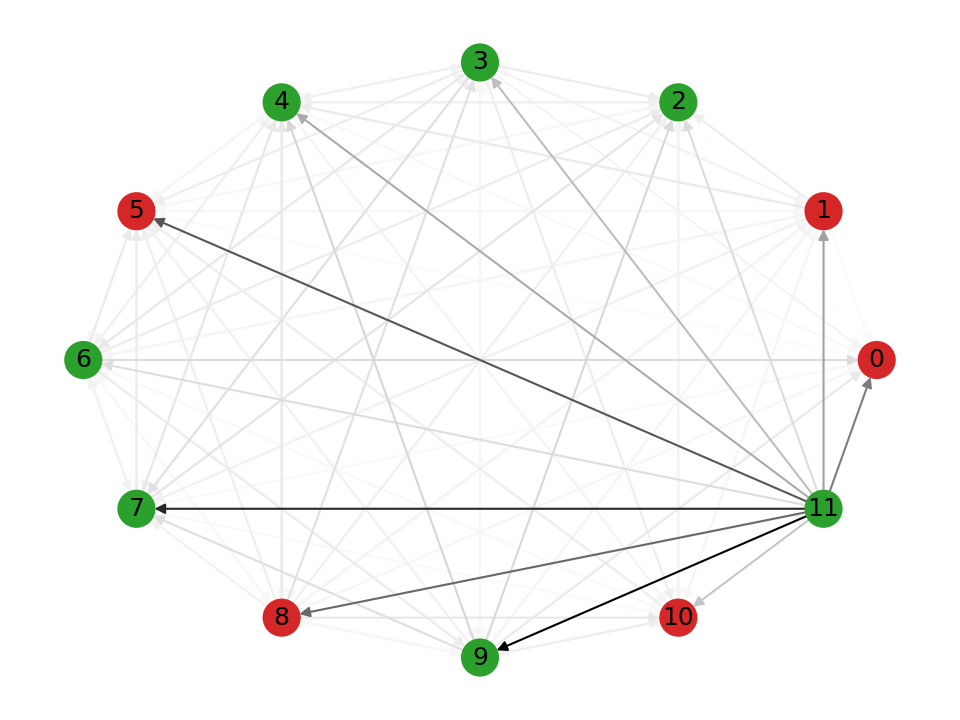

Figure graph saved as {'png'}


In [66]:
G = nx.from_numpy_matrix(R.cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

colors = 'C1'
colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

try:
    pos = nx.planar_layout(G)
except:
#     pos = nx.spring_layout(G)
    pos = nx.circular_layout(G)

kwargs = dict(pos=pos, node_color=colors, with_labels=True,
              edgelist=edges, edge_color=weights,
              edge_cmap=plt.get_cmap('binary'), vmin=0)
plt.figure()
nx.draw(G, **kwargs)
# util.save_figure(f'{run_name}_graph', root=figure_dir)
# util.save_figure(f'graph', root=figure_dir)

<IPython.core.display.Javascript object>


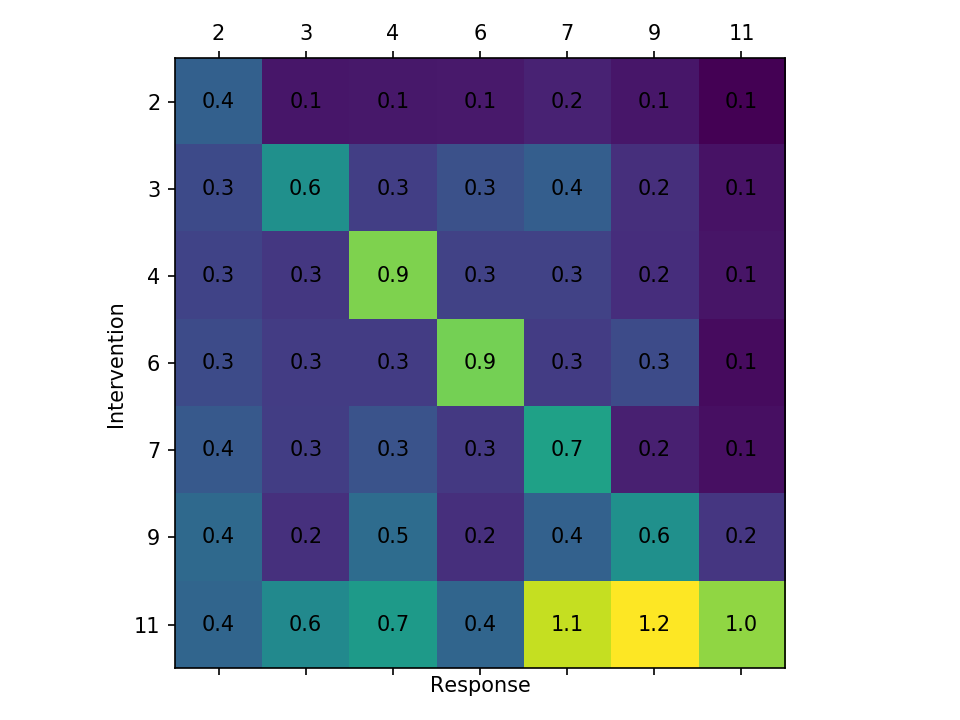

In [67]:
util.plot_mat(R[sel][:,sel], val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
# util.save_figure(f'sel_responses', root=figure_dir)

<IPython.core.display.Javascript object>


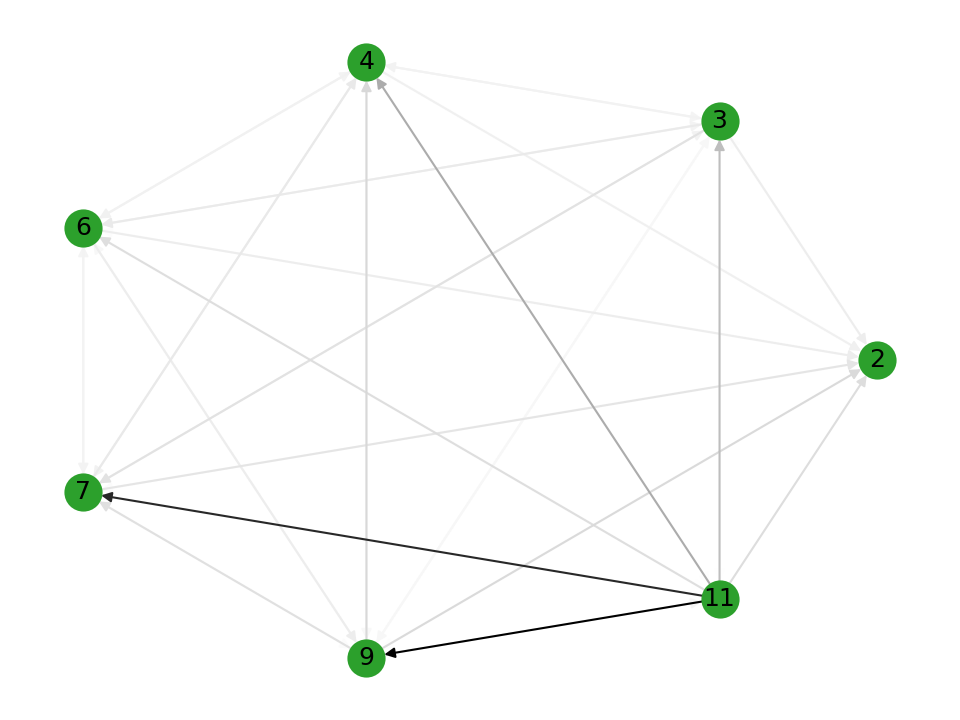

Figure sel-graph saved as {'png'}


In [68]:
G = nx.from_numpy_matrix(R[sel][:,sel].cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

colors = 'C2'
# colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

try:
    pos = nx.planar_layout(G)
except:
#     pos = nx.spring_layout(G)
    pos = nx.circular_layout(G)

kwargs = dict(pos=pos, node_color=colors, labels={i:str(n.item()) for i,n in enumerate(sel)},#, with_labels=True,
              edgelist=edges, edge_color=weights,
              edge_cmap=plt.get_cmap('binary'), vmin=0)
plt.figure()
nx.draw(G, **kwargs)
# util.save_figure(f'{run_name}_graph', root=figure_dir)
util.save_figure(f'sel-graph', root=figure_dir)

In [81]:
from omnilearn import viz as viz_util
import cv2

In [71]:
X = dataset.get_batch(batch_size=64, shuffle=True)

In [72]:
bidx = 0

In [73]:
with torch.no_grad():
    Q = model.encode(X.to(device))
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[bidx]
Q.shape, q.shape

(torch.Size([64, 12]), torch.Size([12]))

In [74]:
n = 16
steps = 40
# info.steps = 20
# info.steps = 7
# info.steps = 5
ntrav = 1
stretch = 0.1

In [77]:
rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
          mnmx=(Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 12, 40, 3, 64, 64])

In [78]:
tH, tW = 4,3
if info['dec_type'] == 's6':
    tH, tW = 6,2
if info['dec_type'] == 's3':
    tH, tW = 3,4

if walks.size(1) != tH*tW:
    tH, tW = util.calc_tiling(walks.size(1))
    
tH, tW

(4, 3)

In [79]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
# print(full.shape)
full = full.squeeze(0).permute(2,0,4,1,5,3).contiguous()
frames = full.view(S, tH*H, tW*W, C).mul(255).byte().numpy()



frames.shape
# full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

(40, 256, 192, 3)

In [82]:

font                   = cv2.FONT_HERSHEY_SIMPLEX
font                   = cv2.FONT_HERSHEY_COMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 1

px, py = 2, 12

for frame in frames:
    for i,j in np.ndindex(tH, tW):
        idx = i*tW+j
        cv2.putText(frame, f'{idx}', 
            (px+H*j, py+W*i), 
            font, 
            fontScale,
            fontColor,
            lineType)


<IPython.core.display.Javascript object>


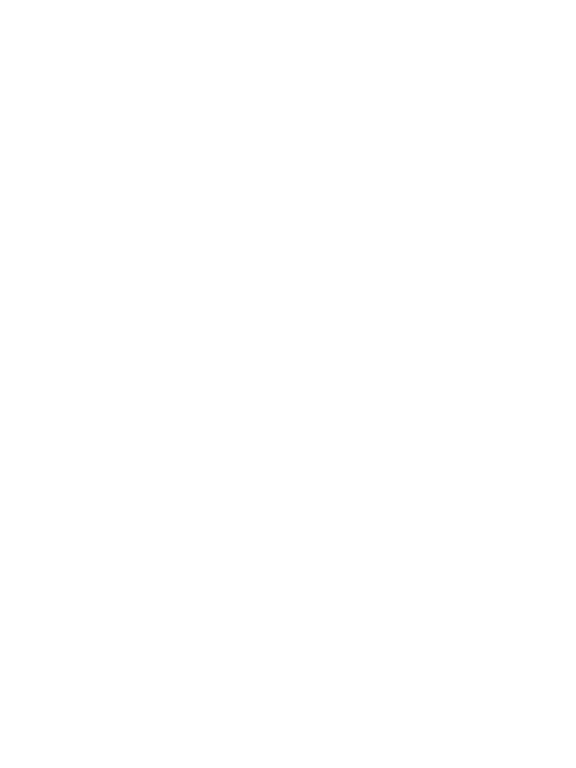

In [83]:
mov = util.Video(frames)
# if figure_dir is not None:
#     path = figure_dir / f'seq{bidx}.mp4'
# #     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
#     mov.export(path)
#     print(f'Movie saved: {str(path)}')
mov.play('jupyter', scale=2)

In [91]:
func = dataset._active.function
func

CPPN(
  (net): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(5, 16, kernel_size=(1, 1), stride=(1, 1))
        (nonlin): Tanh()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (nonlin): Tanh()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (nonlin): Tanh()
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
        (nonlin): Sigmoid()
      )
    )
  )
)

<IPython.core.display.Javascript object>


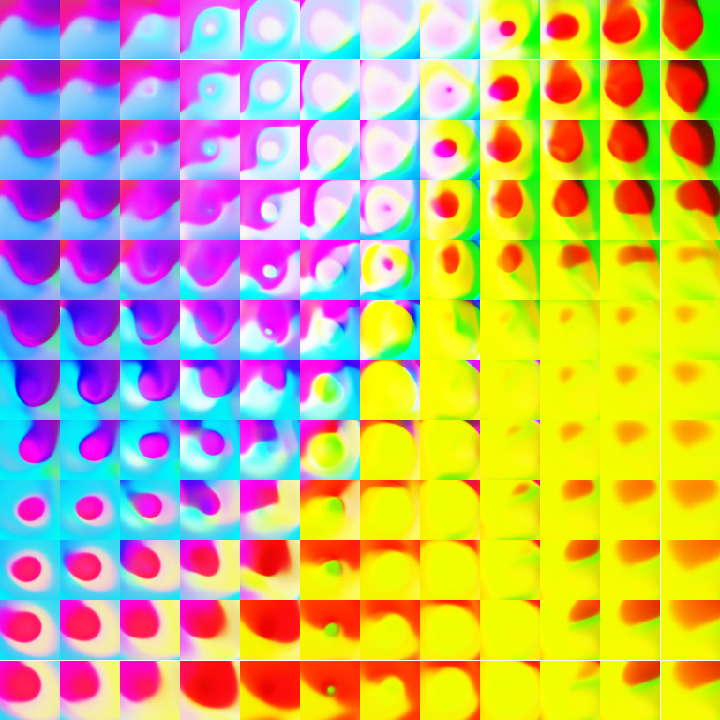

In [96]:
ix, iy = 0, 1
n = 12
D = 12
h, w = n, n
R = 3

noise = torch.randn(h*w, 2, device=device)
cx, cy = torch.meshgrid(torch.linspace(-R,R,h, device=device), torch.linspace(-R,R,h, device=device))
cx, cy = cx.reshape(-1), cy.reshape(-1)
noise[:,ix] = cx
noise[:,iy] = cy
with torch.no_grad():
    vimgs = func(noise)
util.plot_imgs(vimgs);
# util.save_figure(f'cppn_2dtraversal_{cppn_seed}', root=figure_dir)

In [254]:
# util.plot_mat(mats.sum(2).mean(1), val_fmt=1)
# plt.yticks(range(len(factors)), factors)
# plt.xlabel('Latent dimension')
# plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
# pass # which latent dimension responds the most to interventions in the given factor of variation

In [35]:
def ae_cycle(q):
    with torch.no_grad():
        im = model.decode(q.to(device))
        q = model.encode(im)
    return im.cpu(), q.cpu()

def get_loss(im, orig):
    return F.binary_cross_entropy(im,orig)

In [53]:
batch = dataset.get_batch(batch_size=64, shuffle=True)
x = batch
# x, y = batch
x.shape

torch.Size([64, 3, 64, 64])

In [54]:
Im = x.cpu()
with torch.no_grad():
    Q = model.encode(Im.to(device))
    if isinstance(Q, distrib.Distribution):
        Q = Q.loc
    Q = Q.cpu()
q.shape

torch.Size([100, 12])

<IPython.core.display.Javascript object>


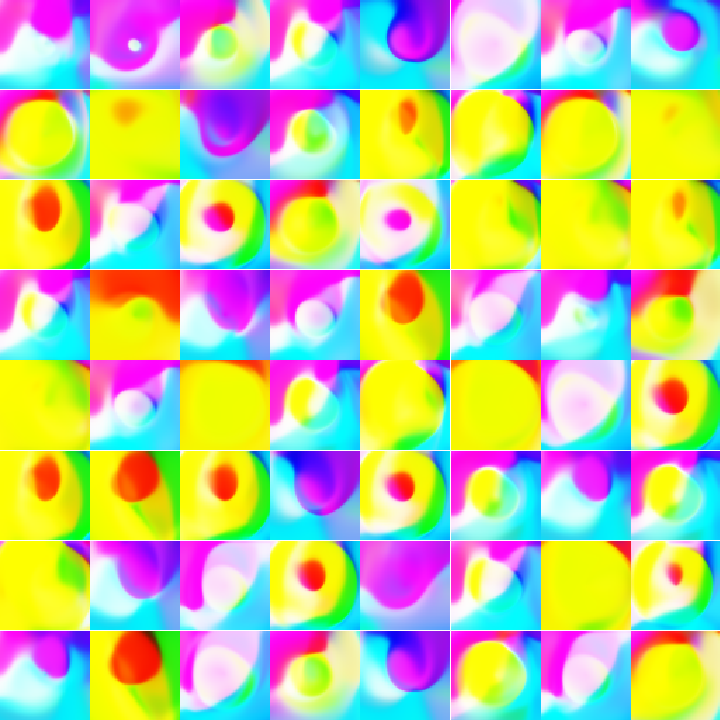

In [55]:
util.plot_imgs(Im);

In [56]:
N = 100

In [57]:
q = Q
prev = Im
Imgs, Qs = [Im], [Q]
for _ in tqdm(range(N)):
    im, q = ae_cycle(q)
    Imgs.append(im)
    Qs.append(q)
Imgs = torch.stack(Imgs)
Qs = torch.stack(Qs)/Q.std(0, keepdim=True).unsqueeze(0)
Imgs.shape, Qs.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

(torch.Size([101, 64, 3, 64, 64]), torch.Size([101, 64, 12]))

In [58]:
L1 = torch.stack([get_loss(i1, i2) for i1, i2 in zip(Imgs[1:], Imgs[:-1])])
D1 = Qs[1:].sub(Qs[:-1]).pow(2).view(N, -1).sum(-1)
L1.shape, D1.shape

(torch.Size([100]), torch.Size([100]))

In [59]:
L = torch.stack([get_loss(i1, i2) for i1, i2 in zip(Imgs[1:], (len(Imgs)-1)*[Imgs[0]])])
D = Qs[1:].sub(Qs[:1]).pow(2).view(N, -1).sum(-1)
L.shape, D.shape

(torch.Size([100]), torch.Size([100]))

<IPython.core.display.Javascript object>


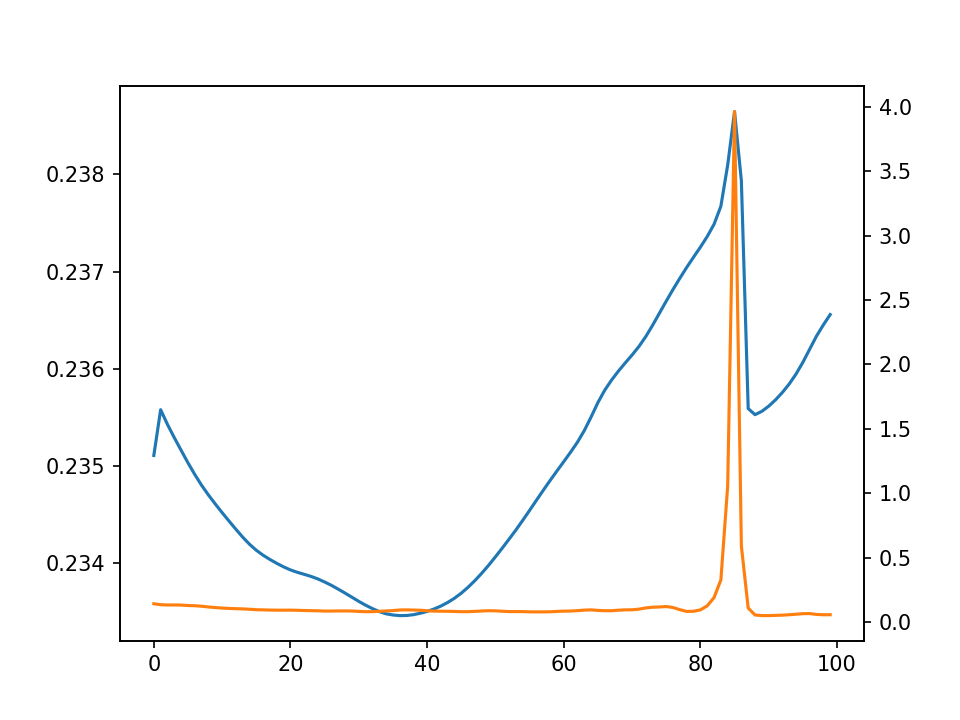

In [60]:
plt.figure()
plt.plot(L1, c='C0');
plt.twinx()
plt.plot(D1, c='C1');

<IPython.core.display.Javascript object>


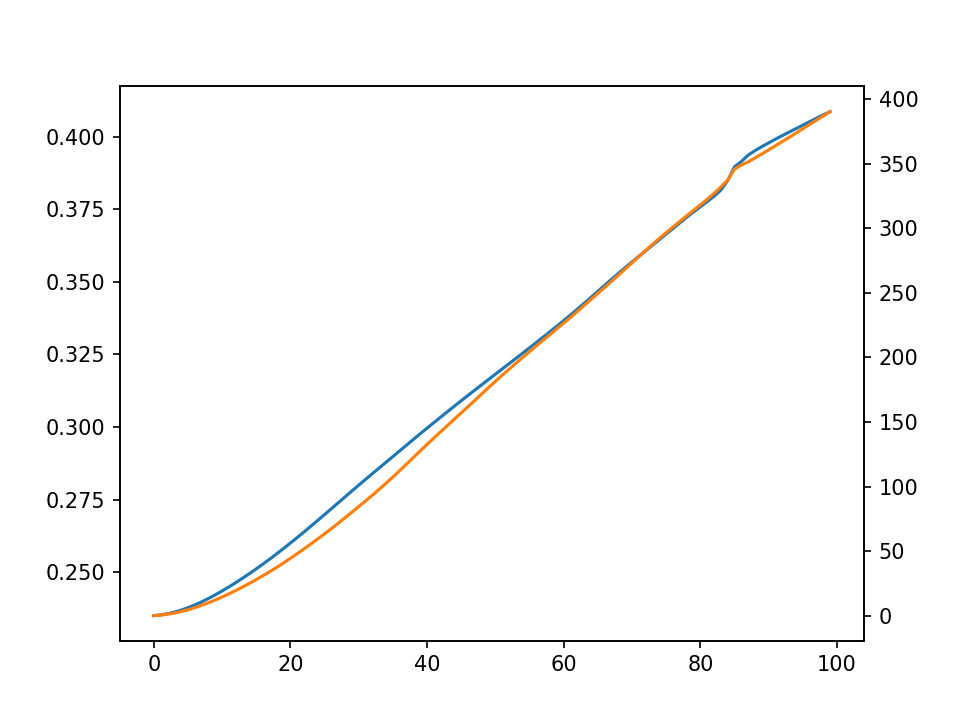

In [61]:
plt.figure()
plt.plot(L, c='C0');
plt.twinx()
plt.plot(D, c='C1');

<IPython.core.display.Javascript object>


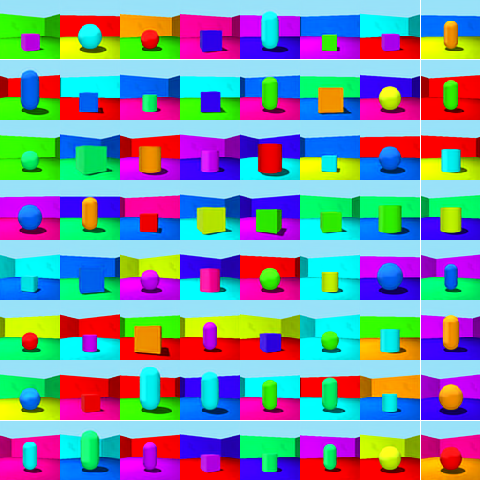

(<Figure size 480x480 with 64 Axes>, <numpy.flatiter at 0x27ea75c9630>)

In [117]:
util.show_imgs(Imgs[10])

<IPython.core.display.Javascript object>


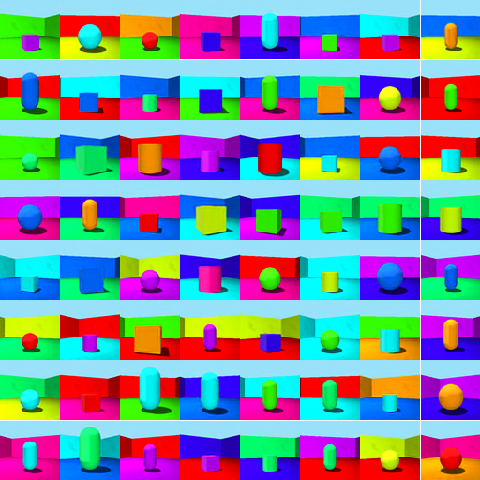

(<Figure size 480x480 with 64 Axes>, <numpy.flatiter at 0x27ea75ca0c0>)

In [124]:
util.show_imgs(Imgs[50])

<IPython.core.display.Javascript object>


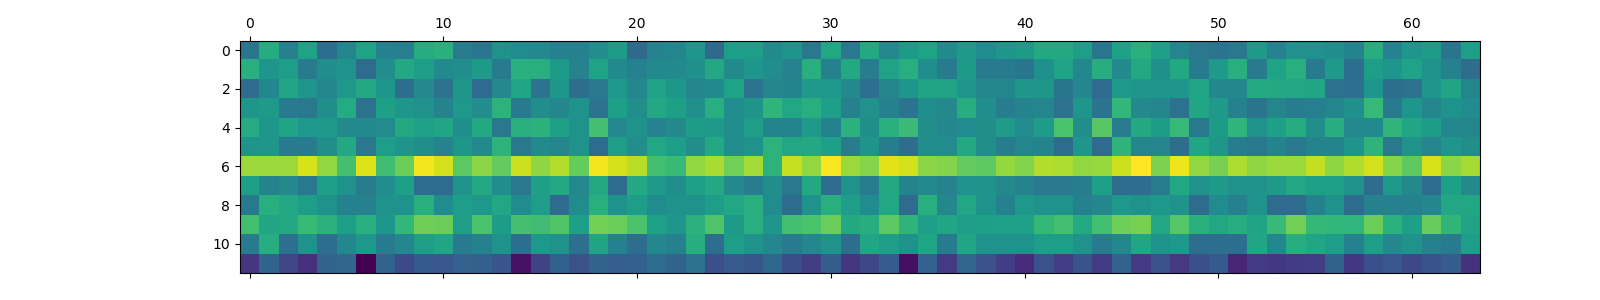

In [148]:
plt.matshow(Qs[0].t())

<IPython.core.display.Javascript object>


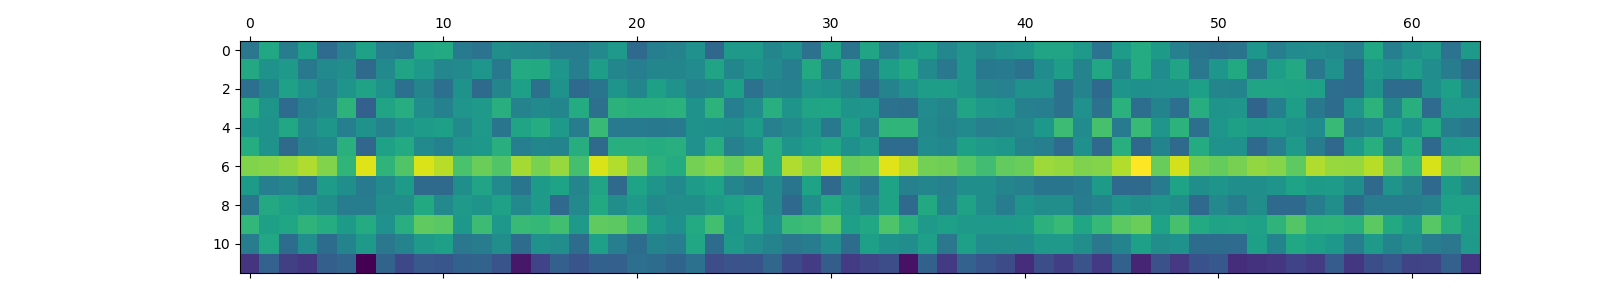

In [149]:
plt.matshow(Qs[-1].t())

<IPython.core.display.Javascript object>


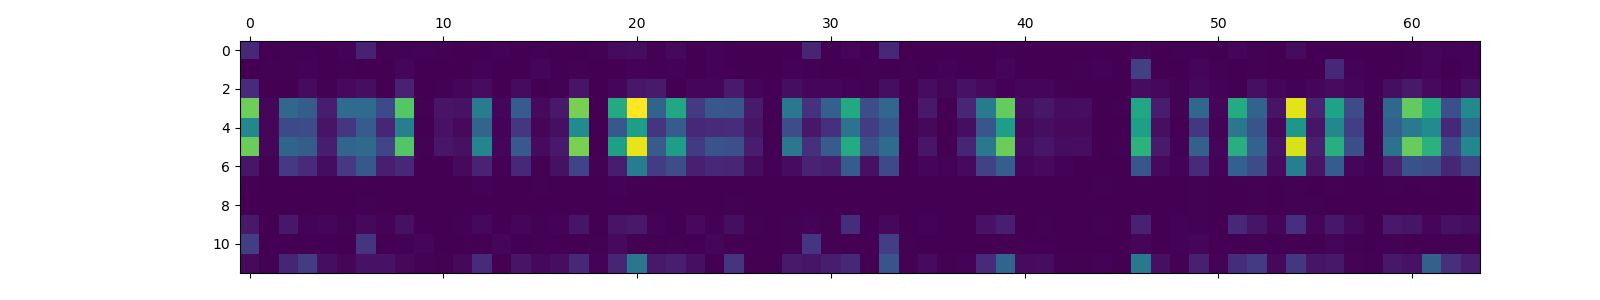

In [150]:
plt.matshow(Qs[-1].sub(Qs[0]).abs().t())

In [ ]:
from omnilearn import viz as viz_util

In [31]:
bidx = 0

In [28]:
X = Im

In [32]:
# X = run[info.results_name]['out']['original']
with torch.no_grad():
    Q = model.encode(X.to(device))
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[bidx]
Q.shape, q.shape

(torch.Size([64, 12]), torch.Size([12]))

In [34]:
n = 16
steps = 40
# info.steps = 20
# info.steps = 7
# info.steps = 5
ntrav = 1
stretch = 0.1

In [48]:
rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
          mnmx=(Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 12, 40, 3, 64, 64])

In [51]:
tH, tW = 4,3
# tH, tW = 6,2
tH, tW

(4, 3)

In [57]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
print(full.shape)
full = full.squeeze(0).permute(2,0,4,1,5,3).contiguous()
full = full.view(S, tH*H, tW*W, C)
# full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

full.shape

torch.Size([1, 4, 3, 40, 3, 64, 64])


torch.Size([40, 256, 192, 3])

In [62]:
mov = util.Video(full.mul(255).byte().numpy())
if figure_dir is not None:
    path = figure_dir / f'{dsname}_{run.name}.mp4'
    mov.export(path)
    print(f'Movie saved: {str(path)}')

Movie saved: figures\metric\3ds_3ds_vae1_e-c12_d-c12_mish_210125-140254.mp4
